# UCluster
Visualizing the pre-processed data for training, testing and evaluation
## Pre-processed data
### Training data
According to the [repository](https://github.com/ViniciusMikuni/UCluster):
> The data is expected to be stored in .h5 files containing the following:  
>- data: [N,P,F],  
>- label:[N,P]  
>- pid: [N]  
>- global: [N,G]  
>
>Where,  
>- N = Number of events  
>- F = Number of features per point  
>- P = Number of points  
>- G = Number of global features  
>
>For Unsupervised multiclass classification, only the pid is required, while for anomaly detection, label and global are required.

Since we are using the anomaly detection one, let's check for these features and what they mean

In [2]:
# Importing some basic libraries
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import nexusformat.nexus as nx

First, we want to see what is inside the file

In [3]:
f = nx.nxload('..\data\\train_20v_RD_100P_2NJET.h5')
print(f.tree)

root:NXroot
  data = float64(367212x100x7)
  global = float64(367212x4)
  label = int8(367212x100)
  masses = float64(367212)
  pid = int8(367212)


There are 5 sets of data. After [checking the code](https://github.com/ViniciusMikuni/UCluster/blob/master/scripts/prepare_data_unsup.py), we found that for the training file there where 400,000 events, from which 367,212 events had two jets or more.   
In general, each h5 pre-processed file has:
- **Data**  
    For each event there is a dataframe of 100 x 7. The rows consist of constituyents particles for both of the most energetic jets, with zero padding until 100. The columns are: 
    1. $\eta_{const}-\eta_{jet}$
    2. $\phi_{const}-\phi{jet}$
    3. $\log\left( \frac{p_{T_{const}}}{p_{T_{jet}}}\right)$
    4. $\log\left( \frac{E_{const}}{E_{jet}}\right)$
    5. $\log(p_{T_{const}})$
    6. $\log (E_{const})$
    7. $\Delta R= \sqrt{\left(\eta_{const}-\eta_{jet}\right)^2+\left(\phi_{const}-\phi_{jet}\right)^2}$
    
- **Global**  
    For each event and for the two principal jets it has: $\log(m_{jet})$ and $\tau_{21}$
    
- **Label**  
    Information about in which part of a range from 10 to 1000 divided in 20 with a upper bound of 100,000 is the mass of each of the principal jets. This information is added for each event, and for each constituent of the jets, with zero padding until 100.
    
- **Masses**  
    Norm squared of the four-momentum vector of the principal jet of each event.
    
- **PID**  
    The true label for each event (0 for background, 1 for signal)

Let's vizualise each variabel
#### Data

In [4]:
with h5py.File('..\data\\train_20v_RD_100P_2NJET.h5', 'r') as hdf:
    hdfdata = hdf.get('data')
    data = np.array(hdfdata)
data.shape

(367212, 100, 7)

We can get the dataframe for the first event and see the distributions of the variables:

In [5]:
columns = ['eta', 'phi', 'ratio_pT', 'ratio_E', 'pT', 'E', 'delta_R']
df = pd.DataFrame(data[0], columns = columns)
df.shape

(100, 7)

In [6]:
df.mean(axis=0)

eta        -0.020297
phi         0.103812
ratio_pT   -3.650434
ratio_E    -3.643657
pT          1.288967
E           1.304195
delta_R     0.181066
dtype: float64

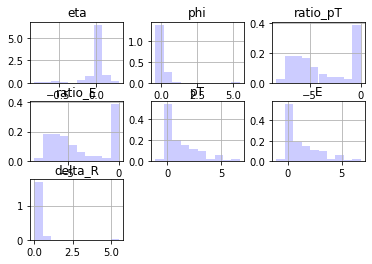

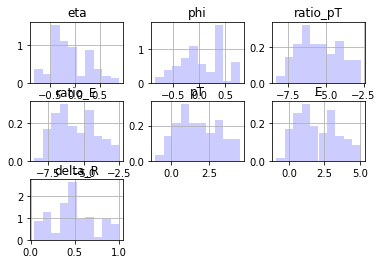

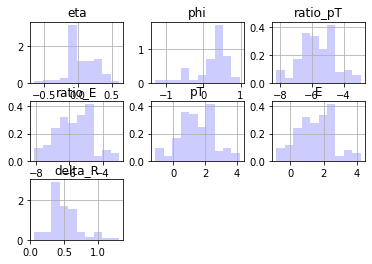

In [7]:
for ii in range(3):
    df_plot = pd.DataFrame(data[ii], columns = columns)
    df_plot.hist(facecolor='b', alpha=0.2, density=True);

To see the distribution of the variables I'll calculate the mean of each variable for each event to have it in a dataframe with the label. Then I can plot the distributions separating signal from background

In [8]:
df = pd.DataFrame(data.mean(axis=(1)), columns = columns)
pid = pd.Series(np.array(h5py.File('..\data\\train_20v_RD_100P_2NJET.h5', 'r')['pid']))
df = df.assign(label=pid.values)
df.head()

,eta,phi,ratio_pT,ratio_E,pT,E,delta_R,label
0,-0.020297,0.103812,-3.650434,-3.643657,1.288967,1.304195,0.181066,0
1,-0.102285,0.048621,-5.436459,-5.587739,1.771213,1.982283,0.488595,0
2,0.057016,0.209191,-5.607668,-5.716557,1.494795,1.525411,0.504339,0
3,0.012093,-1.364511,-5.692059,-5.702109,1.448475,1.535315,1.602382,0
4,0.126981,1.849751,-6.124994,-6.222594,1.001034,1.730127,2.085833,0


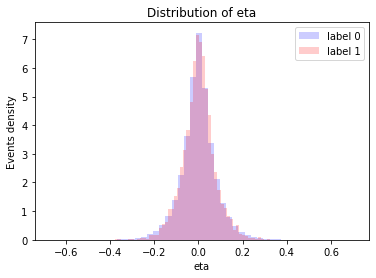

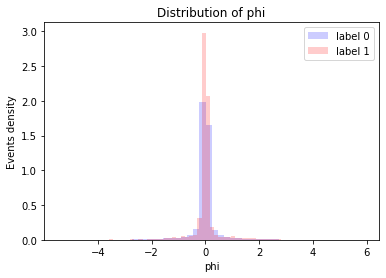

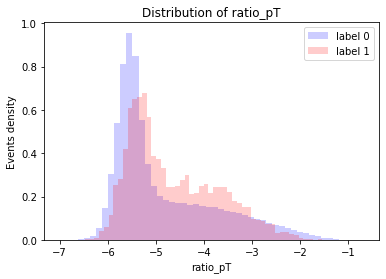

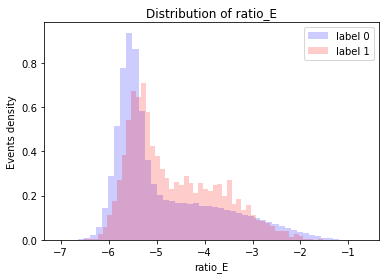

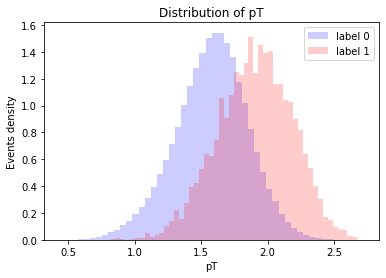

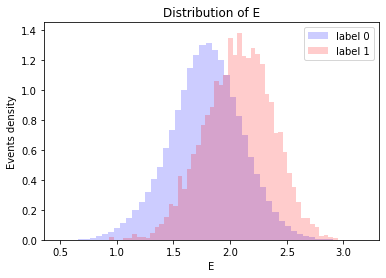

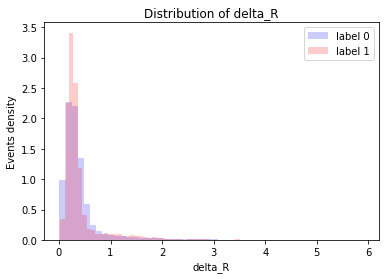

In [9]:
from benchtools.src.plotools import bkg_sig_hist

variables = df.drop('label', axis=1).columns
for variable in variables:
    bkg_sig_hist(df, variable=variable, label='label')
    plt.show()

#### Global
I'll separate the data for each jet and each variable:

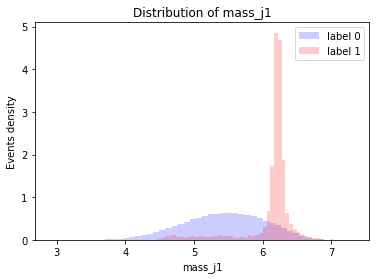

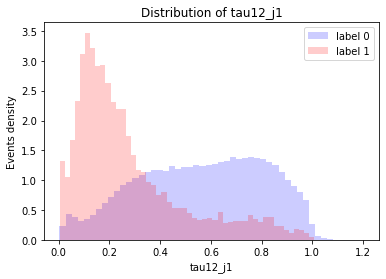

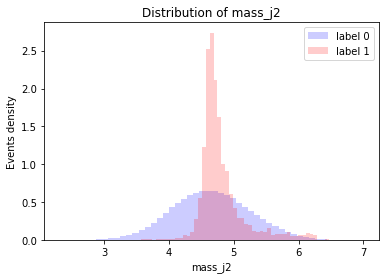

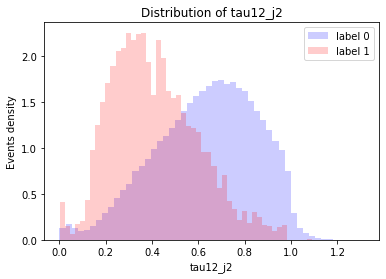

In [10]:
columns=['mass_j1', 'tau12_j1', 'mass_j2', 'tau12_j2']
df_global = pd.DataFrame(np.array(h5py.File('..\data\\train_20v_RD_100P_2NJET.h5', 'r')['global']), columns=columns)
df_global=df_global.assign(label=pid.values)

for variable in columns:
    bkg_sig_hist(df_global, variable=variable, label='label')
    plt.show()

#### Label
For this variable I'll separate the rows for signal and background. Then I'll plot all the values in a histogram

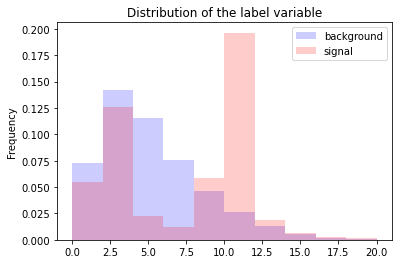

In [11]:
# Loading the label dataframe
df_label = pd.DataFrame(np.array(h5py.File('..\data\\train_20v_RD_100P_2NJET.h5', 'r')['label']))
# Adding the labels
df_label = df_label.assign(label=pid.values)
# Separating signal and background
df_label_bkg = df_label.loc[df_label['label']==0]
df_label_sig = df_label.loc[df_label['label']==1]
# Plotting 
# 'stack' to plot all the values of each dataframe on the histogram
df_label_bkg.drop('label', axis=1).stack().plot.hist(facecolor='b', alpha=0.2, label='background', density=True)
df_label_sig.drop('label', axis=1).stack().plot.hist(facecolor='r', alpha=0.2, label='signal', density=True)
plt.legend(loc='upper right')
plt.title('Distribution of the label variable');

I'll try to substitute the number for the range with the mass values

In [12]:
MASSRANGE = np.linspace(10,1000,20)
MASSRANGE = np.append(MASSRANGE, [100000])
map_list = []
for x in enumerate(MASSRANGE):
    if x[0]==20: break
    map_list.append(x)
df_map = pd.DataFrame(map_list, columns=['value', 'mass'])
df_map.head()

,value,mass
0,0,10.000000
1,1,62.105263
2,2,114.210526
3,3,166.315789
4,4,218.421053


In [13]:
df_map = df_map.set_index("value")["mass"]
df_label_map = pd.DataFrame()
# Mapping the values 
for col in df_label.drop('label', axis=1):
    df_label_map[col] = df_label[col].map(df_map).fillna(df_label[col])
# Adding the labels
df_label_map = df_label_map.assign(label=pid.values)
df_label_map.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,114.210526,114.210526,114.210526,114.210526,114.210526,114.210526,114.210526,114.210526,114.210526,114.210526,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0
1,635.263158,635.263158,635.263158,635.263158,635.263158,635.263158,635.263158,635.263158,635.263158,635.263158,...,478.947368,478.947368,478.947368,478.947368,478.947368,478.947368,478.947368,478.947368,478.947368,0
2,687.368421,687.368421,687.368421,687.368421,687.368421,687.368421,687.368421,687.368421,687.368421,687.368421,...,687.368421,687.368421,687.368421,687.368421,687.368421,687.368421,687.368421,687.368421,687.368421,0
3,531.052632,531.052632,531.052632,531.052632,531.052632,531.052632,531.052632,531.052632,531.052632,531.052632,...,218.421053,218.421053,218.421053,218.421053,218.421053,218.421053,218.421053,218.421053,218.421053,0
4,635.263158,635.263158,635.263158,635.263158,635.263158,635.263158,635.263158,635.263158,635.263158,635.263158,...,635.263158,635.263158,635.263158,635.263158,635.263158,635.263158,635.263158,635.263158,635.263158,0


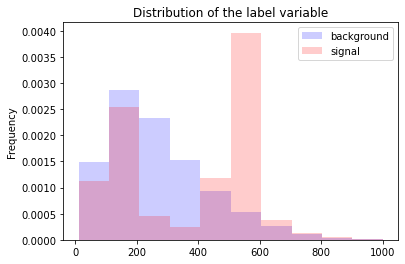

In [14]:
# Separating signal and background
df_label_bkg = df_label_map.loc[df_label_map['label']==0]
df_label_sig = df_label_map.loc[df_label_map['label']==1]
# Plotting 
# 'stack' to plot all the values of each dataframe on the histogram
df_label_bkg.drop('label', axis=1).stack().plot.hist(facecolor='b', alpha=0.2, label='background', density=True)
df_label_sig.drop('label', axis=1).stack().plot.hist(facecolor='r', alpha=0.2, label='signal', density=True)
plt.legend(loc='upper right')
plt.title('Distribution of the label variable');

#### Masses

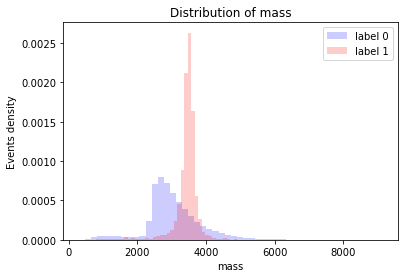

In [15]:
df_masses = pd.DataFrame(np.array(h5py.File('..\data\\train_20v_RD_100P_2NJET.h5', 'r')['masses']), columns=['mass'])
df_masses=df_masses.assign(label=pid.values)
bkg_sig_hist(df_masses, variable='mass', label='label')
plt.show()

The variables for the other files is the same, but let's see how many events had more than 2 jets:

In [16]:
f = nx.nxload('..\data\\test_20v_RD_100P_2NJET.h5')
print(f.tree)

root:NXroot
  data = float64(137681x100x7)
  global = float64(137681x4)
  label = int8(137681x100)
  masses = float64(137681)
  pid = int8(137681)


In [17]:
f = nx.nxload('..\data\eval_20v_RD_100P_2NJET.h5')
print(f.tree)

root:NXroot
  data = float64(312345x100x7)
  global = float64(312345x4)
  label = int8(312345x100)
  masses = float64(312345)
  pid = int8(312345)


- For the *test set* there were processed 149,999 events. 137,681 had two or more jets.
- For the *evaluation set* 312,345 had two jets, from the 340,000 that were processed.

## Output
According to the [script](https://github.com/ViniciusMikuni/UCluster/blob/master/scripts/evaluate_kmeans_seg.py), the output has 5 dataframes: *label*, *pid*, *max_pool*, *global* and *masses*

In [19]:
from benchtools.src.metrictools import performance_metrics, rejection_plot, inverse_roc_plot, significance_plot, precision_recall_plot

In [20]:
f = nx.nxload('..\data\evaluation_full.h5')
print(f.tree)

root:NXroot
  global = float64(312320x4)
  label = int8(312320)
  masses = float64(312320)
  max_pool = float32(312320x2)
  pid = int64(312320)


In [21]:
y_label = pd.DataFrame(np.array(h5py.File('..\data\evaluation_full.h5', 'r')['label']), columns=['label'])
y_pred = pd.DataFrame(np.array(h5py.File('..\data\evaluation_full.h5', 'r')['pid']), columns=['pred'])
y_pred.shape

(312320, 1)

In [22]:
metrics= performance_metrics('Ucluster', label=y_label, pred_label=y_pred)
metrics

Ucluster
****Results****


C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  background       0.99      1.00      1.00    309296
      signal       0.00      0.00      0.00      3024

    accuracy                           0.99    312320
   macro avg       0.50      0.50      0.50    312320
weighted avg       0.98      0.99      0.99    312320



C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Classifier,Recall,Precision,F1 score
0,Ucluster,0.0,0.0,0.0


It appears that the classifier classified everything as background.

I changed the code to get the cluster distance 

### Distances

In [23]:
f = nx.nxload('..\data\evaluation_dist.h5')
print(f.tree)

root:NXroot
  distances = float32(312320x2)
  global = float64(312320x4)
  label = int8(312320)
  masses = float64(312320)
  max_pool = float32(312320x2)
  pid = int64(312320)


In [24]:
y_score = pd.DataFrame(np.array(h5py.File('..\data\evaluation_dist.h5', 'r')['distances']), columns=['dist_0', 'dist_1'])
y_label = pd.DataFrame(np.array(h5py.File('..\data\evaluation_dist.h5', 'r')['label']), columns=['label'])

y_score

,dist_0,dist_1
0,0.010410,10.275502
1,0.020848,9.507950
2,0.000487,9.650536
3,0.007560,9.725061
4,0.015914,10.527639
...,...,...
312315,0.007062,9.281509
312316,0.007038,9.441727
312317,0.003599,9.658307
312318,0.001220,9.930380


Here can be seen why all the events are labeled as background:

In [25]:
y_score = y_score.assign(label=y_label)

min_bkg = y_score['dist_0'].min()
max_bkg = y_score['dist_0'].max()
min_sig = y_score['dist_1'].min()
max_sig = y_score['dist_1'].max()

print('The minimum and maximum distance for background is: {:.3} and {:.3}'.format(min_bkg, max_bkg))
print('The minimum and maximum distance for signal is: {:.3} and {:.3}'.format(min_sig, max_sig))

The minimum and maximum distance for background is: 2.22e-08 and 1.2
The minimum and maximum distance for signal is: 4.44 and 11.8


The curves should look like those of a random classifier

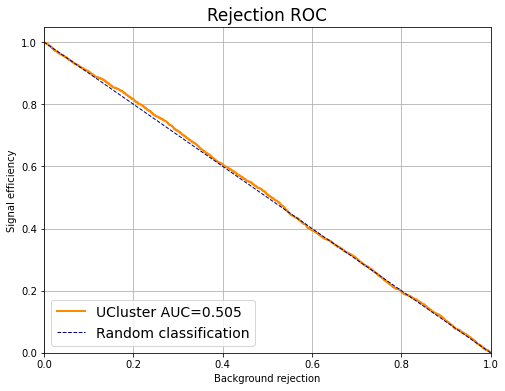

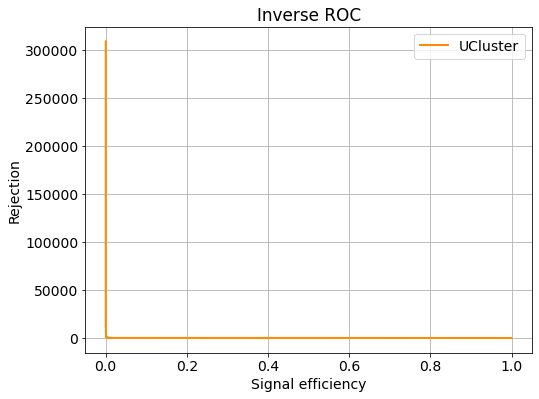

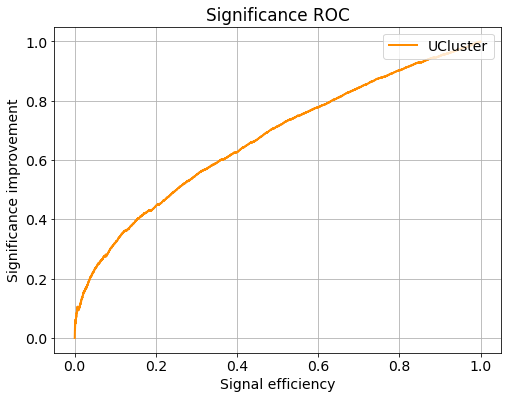

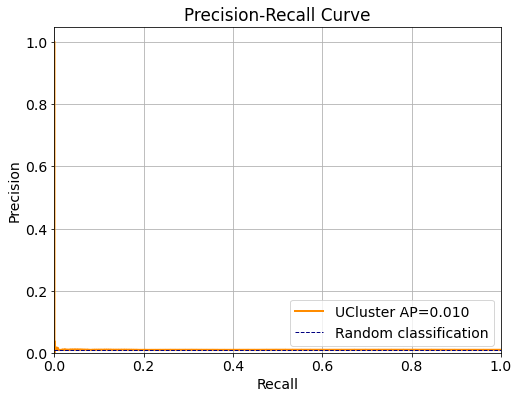

In [26]:
rejection_plot(names='UCluster', labels=y_label.loc[:,'label'], probs=y_score.loc[:,'dist_1'])
plt.show()

inverse_roc_plot(names='UCluster', labels=y_label.loc[:,'label'], probs=y_score.loc[:,'dist_1'])
plt.show()

significance_plot(names='UCluster', labels=y_label.loc[:,'label'], probs=y_score.loc[:,'dist_1'])
plt.show()

precision_recall_plot(names='UCluster', labels=y_label.loc[:,'label'], probs=y_score.loc[:,'dist_1'])
plt.show()

## Multiple runs
I'm trying to run this trying multiple things to see if the classification works. First an old evaluation which I did with little to no change to the code

In [27]:
y_label = pd.DataFrame(np.array(h5py.File('..\data\evaluation.h5', 'r')['label']), columns=['label'])
y_pred = pd.DataFrame(np.array(h5py.File('..\data\evaluation.h5', 'r')['pid']), columns=['pred'])
performance_metrics('Ucluster', label=y_label, pred_label=y_pred)

Ucluster
****Results****
              precision    recall  f1-score   support

  background       0.99      0.93      0.96      3049
      signal       0.00      0.04      0.01        23

    accuracy                           0.92      3072
   macro avg       0.50      0.49      0.48      3072
weighted avg       0.98      0.92      0.95      3072



,Classifier,Recall,Precision,F1 score
0,Ucluster,0.043478,0.458716,0.008299


Still I didn't do better, but at least is not zero. I tried to run that again:

In [29]:
y_label = pd.DataFrame(np.array(h5py.File('..\data\prueba.h5', 'r')['label']), columns=['label'])
y_pred = pd.DataFrame(np.array(h5py.File('..\data\prueba.h5', 'r')['pid']), columns=['pred'])

performance_metrics('Ucluster', label=y_label, pred_label=y_pred)

Ucluster
****Results****
              precision    recall  f1-score   support

  background       0.99      1.00      0.99      3038
      signal       0.00      0.00      0.00        34

    accuracy                           0.99      3072
   macro avg       0.49      0.50      0.50      3072
weighted avg       0.98      0.99      0.98      3072



C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.p

,Classifier,Recall,Precision,F1 score
0,Ucluster,0.0,0.0,0.0


But got zero on everything. Then I tried to change the code because it was giving errors due to trying to use a gpu while the computer doesn't have one. So I changed to the cpu:

In [30]:
y_label = pd.DataFrame(np.array(h5py.File('..\data\pruebacpu.h5', 'r')['label']), columns=['label'])
y_pred = pd.DataFrame(np.array(h5py.File('..\data\pruebacpu.h5', 'r')['pid']), columns=['pred'])

performance_metrics('Ucluster', label=y_label, pred_label=y_pred)

Ucluster
****Results****
              precision    recall  f1-score   support

  background       0.99      1.00      0.99      3038
      signal       0.00      0.00      0.00        34

    accuracy                           0.99      3072
   macro avg       0.49      0.50      0.50      3072
weighted avg       0.98      0.99      0.98      3072



C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.p

,Classifier,Recall,Precision,F1 score
0,Ucluster,0.0,0.0,0.0


Still got zero. Then I tried 60 clusters:

In [31]:
y_label = pd.DataFrame(np.array(h5py.File('..\data\prueba60.h5', 'r')['label']), columns=['label'])
y_pred = pd.DataFrame(np.array(h5py.File('..\data\prueba60.h5', 'r')['pid']), columns=['pred'])

performance_metrics('Ucluster', label=y_label, pred_label=y_pred)

Ucluster
****Results****
              precision    recall  f1-score   support

  background       0.99      1.00      0.99      3038
      signal       0.00      0.00      0.00        34

    accuracy                           0.99      3072
   macro avg       0.49      0.50      0.50      3072
weighted avg       0.98      0.99      0.98      3072



C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.p

,Classifier,Recall,Precision,F1 score
0,Ucluster,0.0,0.0,0.0
